<a href="https://colab.research.google.com/github/singwang-cn/Neural-Network/blob/master/2_layer_Neural_Network_with_bp_by_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [66]:
data_tr_df = pd.read_csv("/content/sample_data/mnist_train_small.csv")
data_te_df = pd.read_csv("/content/sample_data/mnist_test.csv")
data_tr_df.rename(columns={data_tr_df.columns[0]: "target"}, inplace=True)
data_te_df.rename(columns={data_te_df.columns[0]: "target"}, inplace=True)
data_tr_la = np.array(data_tr_df['target'])
data_tr_ta = np.zeros([data_tr_la.size, 10])
for i in range(data_tr_la.size):
  data_tr_ta[i][data_tr_la[i]] = 1
data_tr_im = np.array(data_tr_df.drop(columns=['target']))
data_te_la = np.array(data_te_df['target'])
data_te_ta = np.zeros([data_te_la.size, 10])
for i in range(data_te_la.size):
  data_te_ta[i][data_te_la[i]] = 1
data_te_im = np.array(data_te_df.drop(columns=['target']))

In [394]:
class neural_network():
  def __init__(self, input_size, hidden_size, output_size, weight_init=0.1):
    self.w1 = weight_init * np.random.rand(input_size, hidden_size)
    self.b1 = np.zeros(hidden_size)
    self.w2 = weight_init * np.random.rand(hidden_size, output_size)
    self.b2 = np.zeros(output_size)

  def sigmoid(self, x):
    return 1.0 / (1.0 + np.exp(-x))

  def softmax(self, a):
    c = np.max(a)
    e_a = np.exp(a-c)
    sum_e_a = np.sum(e_a)
    return e_a / sum_e_a

  def forward(self, x):
    a1 = np.dot(x, self.w1) + self.b1
    z1 = self.sigmoid(a1)
    a2 = np.dot(z1, self.w2) + self.b2
    y = self.softmax(a2)
    return y

  def cross_entropy_error(self, y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

  def cost_function(self, data, target):
    error_list = [self.cross_entropy_error(self.forward(data[i]), target[i]) for i in range(data.shape[0])]
    return np.sum(np.array(error_list) / data.shape[0])
      
  def gradient(self, data, target):
    h = 1e-4
    grad_w1 = np.zeros_like(self.w1)
    grad_w2 = np.zeros_like(self.w2)
    grad_b1 = np.zeros_like(self.b1)
    grad_b2 = np.zeros_like(self.b2)
    for i in range(self.w1.shape[0]):
      for j in range(self.w1.shape[1]):
        w_ij = self.w1[i][j]
        self.w1[i][j] = w_ij-h
        y_l = self.cost_function(data, target)
        self.w1[i][j] = w_ij+h
        y_r = self.cost_function(data, target)
        grad_w1[i][j] = (y_r-y_l) / (2*h)
        self.w1[i][j] = w_ij
    for i in range(self.w2.shape[0]):
      for j in range(self.w2.shape[1]):
        w_ij = self.w2[i][j]
        self.w2[i][j] = w_ij-h
        y_l = self.cost_function(data, target)
        self.w2[i][j] = w_ij+h
        y_r = self.cost_function(data, target)
        grad_w2[i][j] = (y_r-y_l) / (2*h)
        self.w2[i][j] = w_ij
    for i in range(self.b1.size):
      b_i = self.b1[i]
      self.b1[i] = b_i-h
      y_l = self.cost_function(data, target)
      self.b1[i] = b_i+h
      y_r = self.cost_function(data, target)
      grad_b1[i] = (y_r-y_l) / (2*h)
      self.b1[i] = b_i
    for i in range(self.b2.size):
      b_i = self.b2[i]
      self.b2[i] = b_i-h
      y_l = self.cost_function(data, target)
      self.b2[i] = b_i+h
      y_r = self.cost_function(data, target)
      grad_b2[i] = (y_r-y_l) / (2*h)
      self.b2[i] = b_i
    return grad_w1, grad_w2, grad_b1, grad_b2
  
  def gradient_backpropagation(self, data, target):
    a1 = np.dot(data, self.w1) + self.b1
    z1 = self.sigmoid(a1)
    a2 = np.dot(z1, self.w2) + self.b2

    error_fw = self.softmax(a2)
    error_softmax = (error_fw-target) / target.shape[0]

    grad_b2 = np.sum(error_softmax, axis=0)
    grad_w2 = np.dot(z1.T, error_softmax)

    error_l2 = np.dot(error_softmax, self.w2.T)
    error_sigmoid = error_l2*(1.-z1)*z1

    grad_b1 = np.sum(error_sigmoid, axis=0)
    grad_w1 = np.dot(data.T, error_sigmoid)

    return grad_w1, grad_w2, grad_b1, grad_b2

  def train(self, data, target, learning_rate = 0.01, times = 100, batch = False):
    error = np.zeros(times)
    if batch:
      for i in range(times):
        batch_size = 100
        index = data.shape[0]
        index_batch = np.random.choice(index, batch_size, replace=True)
        data_batch = data[index_batch]
        target_batch = target[index_batch]
        grad_w1, grad_w2, grad_b1, grad_b2 = self.gradient_backpropagation(data_batch, target_batch)
        self.w1 -= learning_rate * grad_w1
        self.w2 -= learning_rate * grad_w2
        self.b1 -= learning_rate * grad_b1
        self.b2 -= learning_rate * grad_b2
        error[i] = self.cost_function(data_batch, target_batch)
    else:
      for i in range(times):
        grad_w1, grad_w2, grad_b1, grad_b2 = self.gradient_backpropagation(data, target)
        self.w1 -= learning_rate * grad_w1
        self.w2 -= learning_rate * grad_w2
        self.b1 -= learning_rate * grad_b1
        self.b2 -= learning_rate * grad_b2
        error[i] = self.cost_function(data, target)
    return error

  def recognize(self, x):
    return np.argmax(self.forward(x))

In [395]:
nn = neural_network(784, 100, 10, weight_init=0.1)
error = nn.train(data_tr_im[0:100]/255, data_tr_ta[0:100], 0.3, 2000, batch=False)

In [385]:
correct = 0
for i in range(data_te_ta.shape[0]):
  if data_te_ta[i][nn.recognize(data_te_im[i])] == 1:
    correct += 1
print("Accuracy: {:.2%}".format(correct / data_te_ta.shape[0]))

Accuracy: 11.35%


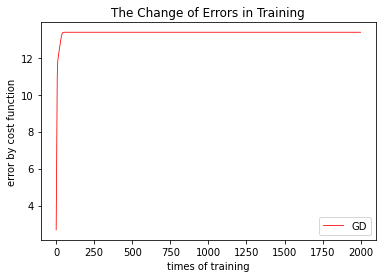

In [396]:
times = np.arange(0, 2000, 1)
plt.figure("Training of naive neural network")
plt.title("The Change of Errors in Training")
plt.xlabel("times of training")
plt.ylabel("error by cost function")
plt.plot(times, error, 'r', label='GD', linewidth=0.8)
plt.legend()